In [1]:
import sys
import json
import torch
import torch.nn.functional as F
import random
import numpy as np
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt

sys.path.append("/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/fairseq")
sys.path.append("/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/fairseq/examples/MMPT")
from mmpt.models import MMPTModel

/sailhome/yuhuiz/develop/miniconda3/envs/openclip/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model, tokenizer, aligner = MMPTModel.from_pretrained("/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/fairseq/examples/MMPT/projects/retri/videoclip/how2.yaml")
model = model.eval().cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing MMBertForEncoder: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.encoder.layer.6.attention.self.query.weight', 'bert.encoder.layer.6.attention.self.query.bias', 'bert.encoder.layer.6.attention.self.key.weight', 'bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.6.attention.self.value.weight', 'bert.encoder.layer.6.attention.self.value.bias', 'bert.encoder.layer.6.attention.output.dense.weight', 'bert.encoder.layer.6.attention.output.dense.bias', 'bert.encoder.layer.6.intermediate.dense.weight', 'bert.encoder.layer.6.intermediate.dense.bias', 'bert.encoder.layer.6.output.dense.weight', 'bert.encoder.layer.6.output.dense.bias', 'bert.enc

In [3]:
data = json.load(open('/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/test_videodatainfo.json'))
video2caption = {}
for item in data['sentences']:
    video_id, caption = item['video_id'], item['caption']
    if video_id not in video2caption: video2caption[video_id] = []
    video2caption[video_id].append(item['caption'])

import random
random.seed(1234)
for key in video2caption: 
    random_idx = random.randint(0, len(video2caption[key]) - 1)
    video2caption[key] = video2caption[key][random_idx]

In [8]:
len(video2caption)

2990

In [9]:
import random
random.seed(1234)
sampled_keys = random.sample(list(video2caption.keys()), 2990)
print(sampled_keys[:5])

['video7881', 'video8161', 'video9325', 'video7043', 'video7012']


In [10]:
def load_video(filename=f'/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/TestVideo/{sampled_keys[0]}.mp4'):
    cap = cv2.VideoCapture(filename)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

    fc = 0
    ret = True

    while (fc < frameCount and ret):
        ret, buf[fc] = cap.read()
        fc += 1

    cap.release()
    return buf

In [11]:
text_features, video_features = [], []
data = []
for key in tqdm(sampled_keys):
    caption = video2caption[key]
    video = load_video(f'/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/TestVideo/{key}.mp4')
    n_frame = video.shape[0]
    n_second = n_frame // 30
    st = (n_frame - n_second * 30) // 2
    video = video[st: st + n_second * 30, ...].astype(float)
    video /= 255
    
    video_frames = torch.tensor(video).view(1, n_second, 30, video.shape[1], video.shape[2], video.shape[3]).type(torch.float32)
    caps, cmasks = aligner._build_text_seq(
        tokenizer(caption, add_special_tokens=False)["input_ids"]
    )

    caps, cmasks = caps[None, :], cmasks[None, :]  # bsz=1

    with torch.no_grad():
        video_frames, caps, cmasks = video_frames.cuda(), caps.cuda(), cmasks.cuda()
        output = model(video_frames, caps, cmasks, return_score=False)
    text_features.append(output['pooled_text'])
    video_features.append(output['pooled_video'])
    data.append({
        "x_embed": F.normalize(output['pooled_video']).squeeze().cpu().numpy(),
        "y_embed": F.normalize(output['pooled_text']).squeeze().cpu().numpy(),
        "y": caption,
    })
    # print(data)
    # print(np.linalg.norm(data[0]['x_embed']))
    # break

100%|██████████| 2990/2990 [45:53<00:00,  1.09it/s] 


In [12]:
import pickle
with open('data_videoclip_3k.pkl', 'wb') as f:
    pickle.dump(data, f)

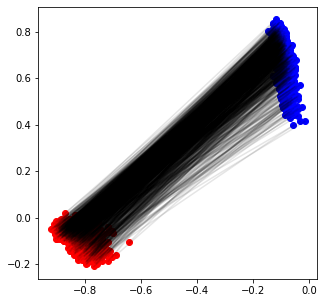

In [9]:
# Use PCA to reduce dimensionality
all_img_features = torch.cat(video_features, dim=0).cpu()
all_text_features = torch.cat(text_features, dim=0).cpu()
all_img_features = F.normalize(all_img_features, dim=1)
all_text_features = F.normalize(all_text_features, dim=1)

# np.save('features_videoclip_random.npy', [all_img_features.numpy(), all_text_features.numpy()])

def svd(X, n_components=2):
    # using SVD to compute eigenvectors and eigenvalues
    # M = np.mean(X, axis=0)
    # X = X - M
    U, S, Vt = np.linalg.svd(X)
    # print(S)
    return U[:, :n_components] * S[:n_components]

features_2d = svd(torch.cat([all_img_features, all_text_features], 0).detach().numpy())
plt.figure(figsize=(5, 5))
plt.scatter(features_2d[:-len(all_img_features), 0], features_2d[:-len(all_img_features), 1], c='red')
plt.scatter(features_2d[-len(all_img_features):, 0], features_2d[-len(all_img_features):, 1], c='blue')
# connect the dots
for i in range(len(all_img_features)):
    plt.plot([features_2d[i, 0], features_2d[len(all_img_features)+i, 0]], [features_2d[i, 1], features_2d[len(all_img_features)+i, 1]], c='black', alpha=0.1)